<a href="https://colab.research.google.com/github/vikas-hkk/Lild4o0d8/blob/main/nlp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install transformers sentencepiece -q

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
import pandas as pd
import re
import inflect
import torch

# Check for GPU availability and force GPU usage
if not torch.cuda.is_available():
    raise RuntimeError("GPU is not available in this Colab session. Please enable GPU via Runtime > Change runtime type > GPU")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Flan-T5 Large Model with forced GPU placement
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)  # Explicitly move to GPU
summarizer = pipeline(
    "summarization",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1  # Force GPU device 0
)

# Initialize inflect engine for number conversion
p = inflect.engine()

# Function to normalize numbers (e.g., "5M" → "5 Million")
def normalize_numbers(text):
    text = re.sub(r"(\d+)M\b", lambda m: p.number_to_words(int(m.group(1))) + " million", text, flags=re.IGNORECASE)
    text = re.sub(r"(\d+)B\b", lambda m: p.number_to_words(int(m.group(1))) + " billion", text, flags=re.IGNORECASE)
    text = re.sub(r"(\d+)K\b", lambda m: p.number_to_words(int(m.group(1))) + " thousand", text, flags=re.IGNORECASE)
    return text

# Function to clean text
def clean_text(text, lowercase=True):
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9.,$% ]", " ", text)  # Remove special characters (keep numbers, $, %)
    text = text.encode("utf-8", "ignore").decode()  # Fix encoding issues
    text = normalize_numbers(text)  # Convert "5M" → "5 Million"
    text = text.lower() if lowercase else text  # Convert to lowercase if needed
    return text.strip()

# Function to count tokens
def count_tokens(text):
    return len(tokenizer.encode(text, truncation=False))

# Function to summarize text with strict token control
def summarize_text(text):
    text = clean_text(text)  # Apply preprocessing

    # Tokenize and check length
    tokens = tokenizer.encode(text, truncation=False)
    if len(tokens) > 2064:
        return None  # Ignore texts longer than 2064 tokens

    # Generate summary with strict output length
    summary = summarizer(
        f"summarize: {text}",
        max_length=512,
        min_length=480,  # Ensuring reasonable length
        do_sample=False  # Deterministic output
    )[0]['summary_text']

    return summary

# Load dataset
file_path = "/content/drive/MyDrive/token_counts.csv"  # Change to actual file path
df = pd.read_csv(file_path)

# Ensure text is string type
df["text"] = df["text"].astype(str)

# Apply summarization only to texts within the 2064 token limit
df["summary"] = df["text"].apply(lambda x: summarize_text(x) if count_tokens(x) <= 2064 else None)

# Remove rows where text exceeded 2064 tokens (ignored in summarization)
df = df.dropna(subset=["summary"])

# Update token count after summarization
df["summary_token_count"] = df["summary"].apply(lambda x: count_tokens(x))

# Save processed file
output_path = "/content/drive/MyDrive/token_540.csv"
df.to_csv(output_path, index=False)

# Print summary of token counts
print("🔍 Token Count Statistics After Summarization:")
print(df["summary_token_count"].describe())  # Shows min, max, avg token count

print(f"✅ Summarization completed! Download the file from: {output_path}")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0
Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Your max_length is set to 512, but your input_length is only 381. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=190)
Your max_length is set to 512, but your input_length is only 432. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=216)
Your max_length is set to 512, but your input_length is only 508. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider de

🔍 Token Count Statistics After Summarization:
count    294.000000
mean     480.462585
std       70.755771
min       27.000000
25%      484.250000
50%      496.000000
75%      512.000000
max      512.000000
Name: summary_token_count, dtype: float64
✅ Summarization completed! Download the file from: /content/drive/MyDrive/token_540.csv


FINBERT

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.preprocessing import MinMaxScaler

# Load the CSV file with summaries
df = pd.read_csv("/content/Target_summary.csv")

# Load FinBERT model from yiyanghkust/finbert-tone
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Prepare results
finbert_scores = {
    "positive_score": [],
    "neutral_score": [],
    "negative_score": [],
    "final_score": []
}

# Analyze each summary with explicit truncation and padding to max_length 512 tokens
for summary in df['generated_summary']:
    inputs = tokenizer(summary,
                       return_tensors="pt",
                       truncation=True,
                       padding="max_length",
                       max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    scores = outputs.logits.softmax(dim=1).numpy()[0]

    pos, neu, neg = scores[0], scores[1], scores[2]
    finbert_scores["positive_score"].append(pos)
    finbert_scores["neutral_score"].append(neu)
    finbert_scores["negative_score"].append(neg)
    finbert_scores["final_score"].append(pos - neg)

# Add raw scores to DataFrame
df["finbert_positive"] = finbert_scores["positive_score"]
df["finbert_neutral"] = finbert_scores["neutral_score"]
df["finbert_negative"] = finbert_scores["negative_score"]
df["finbert_final_score"] = finbert_scores["final_score"]

# Normalize only the finbert_final_score using MinMaxScaler
scaler = MinMaxScaler()
df["norm_final"] = scaler.fit_transform(df[["finbert_final_score"]])

# Save to CSV and display first 5 rows
df.to_csv("finbert_scored_normalized.csv", index=False)
print(df.head())


     pub_date                                               text  \
0  13-03-2020  XI'AN, China, March 13, 2020 /PRNewswire/ -- L...   
1  16-03-2020  NEW YORK and TEL AVIV, Israel, March 16, 2020 ...   
2  17-03-2020  NEW YORK, March 17, 2020 /PRNewswire/ -- Today...   
3  18-03-2020  LONDON, March 18, 2020 /PRNewswire/ --SoftIron...   
4  19-03-2020  AUSTIN, Texas, March 19, 2020 /PRNewswire/ -- ...   

                                   generated_summary  finbert_positive  \
0  XI'AN, China, March 13, 2020 /PRNewswire/ -- L...          0.999266   
1  NEW YORK and TEL AVIV, Israel, March 16, 2020 ...          0.809968   
2  NEW YORK, March 17, 2020 /PRNewswire/ -- Today...          0.999973   
3  LONDON, March 18, 2020 /PRNewswire/ --SoftIron...          0.003220   
4  AUSTIN, Texas, March 19, 2020 /PRNewswire/ -- ...          0.869205   

   finbert_neutral  finbert_negative  finbert_final_score  norm_final  
0         0.000725      9.158913e-06             0.999257    0.999629  
1 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


BERT

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.preprocessing import MinMaxScaler

# Load the CSV file with summaries
df = pd.read_csv("/content/Target_summary.csv")

# Load BERT sentiment model
model_name = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Prepare results
bert_scores = {
    "positive_score": [],
    "negative_score": [],
    "final_score": []
}

# Analyze each summary
for summary in df['generated_summary']:
    inputs = tokenizer(summary, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1).numpy()[0]
    pos, neg = probs[1], probs[0]

    bert_scores["positive_score"].append(pos)
    bert_scores["negative_score"].append(neg)
    bert_scores["final_score"].append(pos - neg)

# Add raw scores
df["bert_positive"] = bert_scores["positive_score"]
df["bert_negative"] = bert_scores["negative_score"]
df["bert_final_score"] = bert_scores["final_score"]

# Normalize
scaler = MinMaxScaler()
norm = scaler.fit_transform(df[["bert_positive", "bert_negative", "bert_final_score"]])
norm_df = pd.DataFrame(norm, columns=["bert_norm_pos", "bert_norm_neg", "bert_norm_final"])
df = pd.concat([df, norm_df], axis=1)

# Save and preview
df.to_csv("bert_scored_normalized.csv", index=False)
print(df.head())


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

     pub_date                                               text  \
0  13-03-2020  XI'AN, China, March 13, 2020 /PRNewswire/ -- L...   
1  16-03-2020  NEW YORK and TEL AVIV, Israel, March 16, 2020 ...   
2  17-03-2020  NEW YORK, March 17, 2020 /PRNewswire/ -- Today...   
3  18-03-2020  LONDON, March 18, 2020 /PRNewswire/ --SoftIron...   
4  19-03-2020  AUSTIN, Texas, March 19, 2020 /PRNewswire/ -- ...   

                                   generated_summary  bert_positive  \
0  XI'AN, China, March 13, 2020 /PRNewswire/ -- L...       0.202995   
1  NEW YORK and TEL AVIV, Israel, March 16, 2020 ...       0.998059   
2  NEW YORK, March 17, 2020 /PRNewswire/ -- Today...       0.991088   
3  LONDON, March 18, 2020 /PRNewswire/ --SoftIron...       0.983689   
4  AUSTIN, Texas, March 19, 2020 /PRNewswire/ -- ...       0.864252   

   bert_negative  bert_final_score  bert_norm_pos  bert_norm_neg  \
0       0.797005         -0.594010       0.202641       0.797359   
1       0.001941          0.

ROBERTA

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.preprocessing import MinMaxScaler

# Load the CSV file
df = pd.read_csv("/content/Target_summary.csv")

# Load RoBERTa sentiment model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Score containers
roberta_scores = {
    "positive_score": [],
    "neutral_score": [],
    "negative_score": [],
    "final_score": []
}

# Analyze each summary
for summary in df['generated_summary']:
    try:
        if pd.isna(summary) or summary.strip() == "":
            raise ValueError("Empty or NaN summary")

        inputs = tokenizer(summary, return_tensors="pt", truncation=True, padding="max_length", max_length=514)
        with torch.no_grad():
            outputs = model(**inputs)

        scores = torch.nn.functional.softmax(outputs.logits, dim=1).numpy()[0]

        if len(scores) != 3:
            raise ValueError("Unexpected output size")

        neg, neu, pos = scores[0], scores[1], scores[2]
    except Exception as e:
        print(f"Skipping row due to error: {e}")
        pos, neu, neg = 0.0, 0.0, 0.0

    roberta_scores["positive_score"].append(pos)
    roberta_scores["neutral_score"].append(neu)
    roberta_scores["negative_score"].append(neg)
    roberta_scores["final_score"].append(pos - neg)

# Add raw scores to DataFrame
df["roberta_positive"] = roberta_scores["positive_score"]
df["roberta_neutral"] = roberta_scores["neutral_score"]
df["roberta_negative"] = roberta_scores["negative_score"]
df["roberta_final_score"] = roberta_scores["final_score"]

# Normalize the scores
scaler = MinMaxScaler()
norm = scaler.fit_transform(df[["roberta_positive", "roberta_neutral", "roberta_negative", "roberta_final_score"]])
norm_df = pd.DataFrame(norm, columns=["roberta_norm_pos", "roberta_norm_neu", "roberta_norm_neg", "roberta_norm_final"])
df = pd.concat([df, norm_df], axis=1)

# Save to CSV and display first 5 rows
df.to_csv("roberta_scored_normalized.csv", index=False)
print(df.head())


Skipping row due to error: index out of range in self
Skipping row due to error: index out of range in self
Skipping row due to error: index out of range in self
Skipping row due to error: index out of range in self
Skipping row due to error: index out of range in self
     pub_date                                               text  \
0  13-03-2020  XI'AN, China, March 13, 2020 /PRNewswire/ -- L...   
1  16-03-2020  NEW YORK and TEL AVIV, Israel, March 16, 2020 ...   
2  17-03-2020  NEW YORK, March 17, 2020 /PRNewswire/ -- Today...   
3  18-03-2020  LONDON, March 18, 2020 /PRNewswire/ --SoftIron...   
4  19-03-2020  AUSTIN, Texas, March 19, 2020 /PRNewswire/ -- ...   

                                   generated_summary  roberta_positive  \
0  XI'AN, China, March 13, 2020 /PRNewswire/ -- L...          0.714931   
1  NEW YORK and TEL AVIV, Israel, March 16, 2020 ...          0.534992   
2  NEW YORK, March 17, 2020 /PRNewswire/ -- Today...          0.634442   
3  LONDON, March 18, 2020

1 DAY - WITHOUT SCORE

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step

=== Evaluation (No FinBERT) ===
MAE  : $11.09
R²   : -1.1446
MAPE : 4.85%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


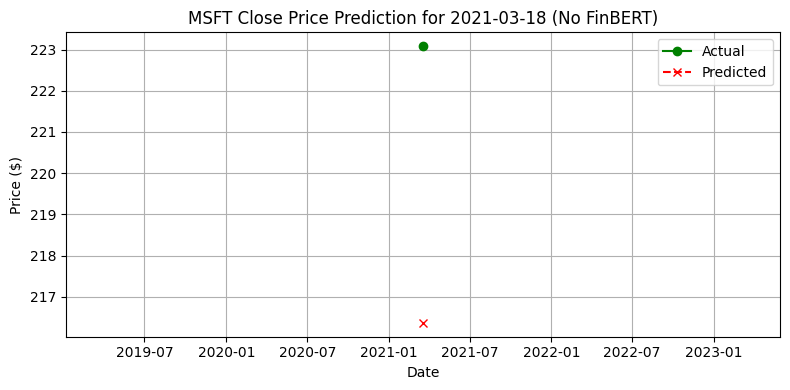


Actual Price on 2021-03-18: $223.08
Predicted Price (No FinBERT): $216.36


In [ ]:
# Install dependencies if needed
# !pip install yfinance scikit-learn tensorflow matplotlib numpy

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Load data
df = yf.download("MSFT", start="2020-01-01", end="2021-03-19", progress=False)

# Features excluding FinBERT
features = ["Open", "High", "Low", "Close", "Volume"]
target = "Close"

# Scale the data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])
df_scaled = pd.DataFrame(scaled, index=df.index, columns=features)

# 2. Create sequences
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(df_scaled) - 1):
    X.append(df_scaled.iloc[i - sequence_length:i].values)
    y.append(df_scaled.iloc[i + 1][target])  # predict next day Close

X = np.array(X)
y = np.array(y)

# 3. Build the model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 4. Train/test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# 5. Predict
y_pred = model.predict(X_test)

# 6. Inverse transform predictions
def inverse_transform(scaler, feature_names, predicted_close):
    dummy = np.zeros((predicted_close.shape[0], len(feature_names)))
    dummy[:, feature_names.index("Close")] = predicted_close.flatten()
    return scaler.inverse_transform(dummy)[:, feature_names.index("Close")]

feature_names = list(df_scaled.columns)
y_pred_inv = inverse_transform(scaler, feature_names, y_pred.flatten())
y_test_inv = inverse_transform(scaler, feature_names, y_test.flatten())

# 7. Evaluate
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100

print("\n=== Evaluation (No FinBERT) ===")
print(f"MAE  : ${mae:.2f}")
print(f"R²   : {r2:.4f}")
print(f"MAPE : {mape:.2f}%")

# 8. Predict 18-03-2021
lookback_data = df_scaled.loc[:'2021-03-17'].iloc[-60:].values.reshape(1, 60, len(features))
pred_next_scaled = model.predict(lookback_data)
pred_next_actual = inverse_transform(scaler, feature_names, pred_next_scaled)

actual_18 = df.loc["2021-03-18"]["Close"]

# 9. Plot
dates = [pd.Timestamp("2021-03-18")]
plt.figure(figsize=(8, 4))
plt.plot(dates, [actual_18], 'go-', label='Actual')
plt.plot(dates, pred_next_actual, 'rx--', label='Predicted')
plt.title("MSFT Close Price Prediction for 2021-03-18 (No FinBERT)")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nActual Price on 2021-03-18: ${actual_18.iloc[0]:.2f}") # Access the first element of the Series using iloc[0]
print(f"Predicted Price (No FinBERT): ${pred_next_actual[0]:.2f}")


In [ ]:
# Ensure actual and predicted values are in the right format
actual = np.array([actual_18])
predicted = pred_next_actual

# 1. Mean Absolute Error (MAE)
mae = mean_absolute_error(actual, predicted)

# 2. Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(actual, predicted) * 100  # as percentage

# 3. R-squared Score (R²)
r2 = r2_score(actual, predicted)

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")


MAE: 10.7327
MAPE: 4.81%
R² Score: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
<ipython-input-8-ce7c9b5437d8>:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "actual": float(actual_value[0]),
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
<ipython-input-8-ce7c9b5437d8>:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "actual": float(actual_value[0]),
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step

--- FinBERT Model ---
Actual Close Price (2021-03-18): $223.08
Predicted Close Price:           $216.65
MAE:  6.4295
MAPE: 2.88%
R²:   nan

--- BERT Model ---
Actual Close Price (2021-03-18): $223.08
Predicted Close Price:           $211.57
MAE:  11.5158
MAPE: 5.16%
R²:   nan

--- RoBERTa Model ---
Actual Close Price (2021-03-18): $223.08
Predicted Close Price:           $216.57
MAE:  6.5159
MAPE: 2.92%
R²:   nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
<ipython-input-8-ce7c9b5437d8>:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "actual": float(actual_value[0]),


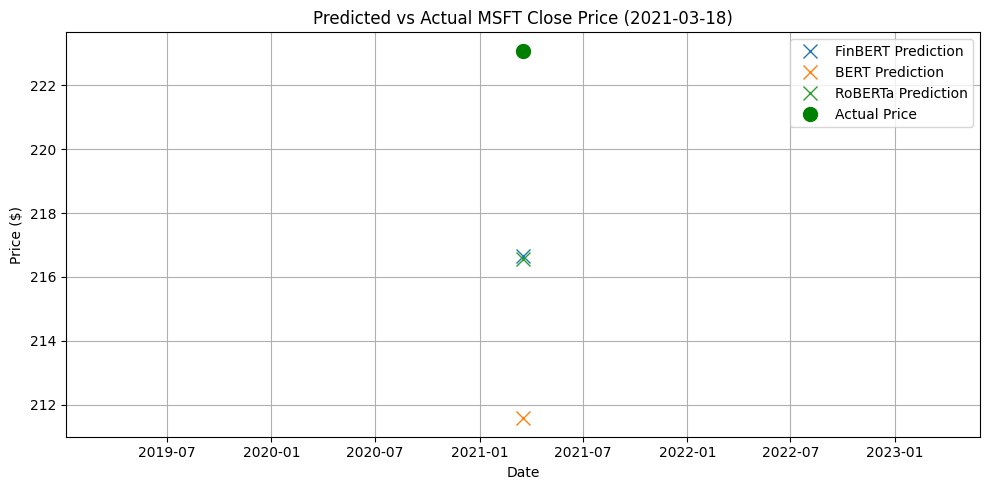

In [ ]:
# Install packages if needed:
# !pip install yfinance scikit-learn tensorflow matplotlib numpy

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# 1. Load MSFT stock data
df = yf.download("MSFT", start="2020-01-01", end="2021-03-19", progress=False)

# 2. Calculate technical indicators
def calculate_indicators(df):
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_50'] = df['Close'].rolling(50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return df.dropna()

df = calculate_indicators(df)

# 3. Add sentiment scores for 2021-03-17
df["FinBERT"] = 0.0
df["BERT"] = 0.0
df["RoBERTa"] = 0.0

if "2021-03-17" in df.index.strftime("%Y-%m-%d"):
    df.loc["2021-03-17", "FinBERT"] = 0.49999472
    df.loc["2021-03-17", "BERT"] = 0.99890983
    df.loc["2021-03-17", "RoBERTa"] = 0.9265822902409968

# 4. Define features and models
base_features = ["Close","SMA_20", "SMA_50", "RSI", "MACD", "OBV"]
sentiment_models = ["FinBERT", "BERT", "RoBERTa"]

# 5. Get actual close price for 2021-03-18
actual_18 = df.loc["2021-03-18"]["Close"]
actual_value = np.array([actual_18])

# 6. Inverse-transform helper
def inverse_transform(scaler, feature_names, predicted_close):
    dummy = np.zeros((predicted_close.shape[0], len(feature_names)))
    dummy[:, feature_names.index("Close")] = predicted_close.flatten()
    return scaler.inverse_transform(dummy)[:, feature_names.index("Close")]

# 7. Train and evaluate models
results = {}
for sentiment in sentiment_models:
    features = base_features + [sentiment]

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[features])
    df_scaled = pd.DataFrame(scaled, index=df.index, columns=features)

    sequence_length = 60
    X, y_arr = [], []
    for i in range(sequence_length, len(df_scaled) - 1):
        X.append(df_scaled.iloc[i - sequence_length:i].values)
        y_arr.append(df_scaled.iloc[i + 1]["Close"])
    X = np.array(X)
    y_arr = np.array(y_arr)

    split = int(len(X) * 0.8)
    X_train, y_train = X[:split], y_arr[:split]
    X_test = X[-1].reshape(1, 60, X.shape[2])

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    pred_next_scaled = model.predict(X_test)
    feature_names = list(df_scaled.columns)
    pred_next_actual = inverse_transform(scaler, feature_names, pred_next_scaled)

    mae = mean_absolute_error(actual_value, pred_next_actual)
    mape = mean_absolute_percentage_error(actual_value, pred_next_actual) * 100
    r2 = r2_score(actual_value, pred_next_actual)

    results[sentiment] = {
        "predicted": float(pred_next_actual[0]),
        "actual": float(actual_value[0]),
        "mae": float(mae),
        "mape": float(mape),
        "r2": float(r2)
    }

# 8. Display results
for model, res in results.items():
    print(f"\n--- {model} Model ---")
    print(f"Actual Close Price (2021-03-18): ${res['actual']:.2f}")
    print(f"Predicted Close Price:           ${res['predicted']:.2f}")
    print(f"MAE:  {res['mae']:.4f}")
    print(f"MAPE: {res['mape']:.2f}%")
    print(f"R²:   {res['r2']:.4f}")

# 9. Plot predictions
plt.figure(figsize=(10, 5))
for model, res in results.items():
    plt.plot([pd.Timestamp("2021-03-18")], [res['predicted']], 'x', markersize=10, label=f'{model} Prediction')
plt.plot([pd.Timestamp("2021-03-18")], [actual_value[0]], 'go', markersize=10, label='Actual Price')
plt.title("Predicted vs Actual MSFT Close Price (2021-03-18)")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


FINBERT 10 DAYS

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step

=== Backtest Results (with FinBERT shift(1)) ===
         Date      Actual   Predicted
0  2021-03-18  223.084488  228.227222
1  2021-03-19  222.726730  227.229979
2  2021-03-22  228.180069  227.286369
3  2021-03-23  229.717438  225.805885
4  2021-03-24  227.667618  228.083293
5  2021-03-25  224.650833  226.348017
6  2021-03-26  228.653824  227.916206
7  2021-03-29  227.454895  229.598157
8  2021-03-31  224.177063  230.404896
9  2021-04-01  227.967316  228.426152

MAE: $2.61
RMSE: $3.32
R²: -0.9332
MAPE: 1.16%


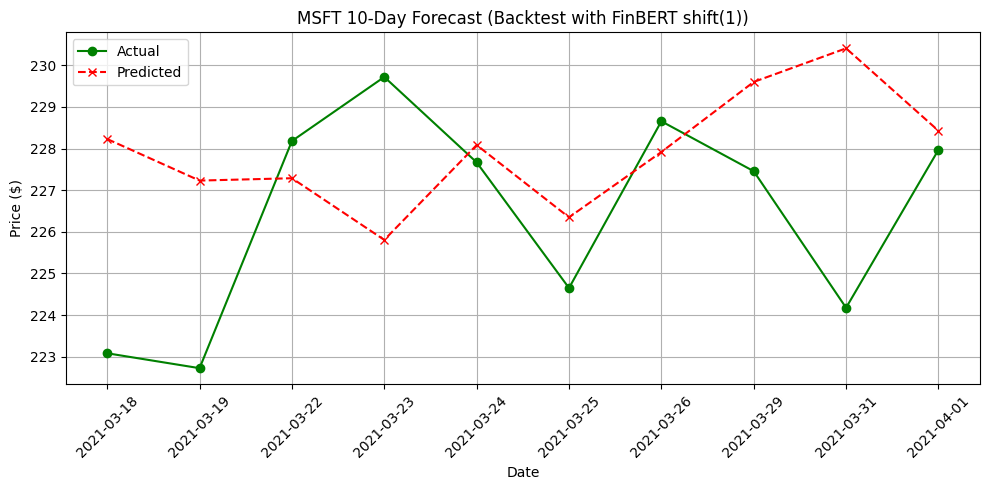

In [ ]:
# Install necessary packages (skip if already installed)
# !pip install yfinance scikit-learn tensorflow matplotlib numpy

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Technical Indicators
def calculate_indicators(df):
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_50'] = df['Close'].rolling(50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return df.dropna()

# 2. Add FinBERT scores with shift(1)
def add_finbert(df):
    finbert_scores = {
        '2021-03-17': 0.49999472,
        '2021-03-18': 0.99511623,
        '2021-03-19': 0.49999523,
        '2021-03-22': 0.99941087,
        '2021-03-23': 0.49999413,
        '2021-03-24': 0.99885404,
        '2021-03-25': 0.87711656,
        '2021-03-26': 0.10364249,
        '2021-03-29': 0.99789953,
        '2021-03-31': 0.96266353
    }
    df['FinBERT'] = 0.0
    for date, score in finbert_scores.items():
        target_date = pd.to_datetime(date) + pd.Timedelta(days=1)
        target_str = target_date.strftime('%Y-%m-%d')
        if target_str in df.index:
            df.at[target_str, 'FinBERT'] = score
    return df

# 3. Prepare data for LSTM
def prepare_data(df):
    features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'OBV', 'FinBERT']
    df = df[features].dropna()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)
    X, y = [], []
    for i in range(90, len(scaled) - 10 + 1):
        X.append(scaled[i-90:i])
        y.append(scaled[i:i+10, 0])  # Predict next 10 days of 'Close'
    return np.array(X), np.array(y), scaler, df

# 4. Build model
def build_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(10)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# 5. Inverse transform
def inverse_transform_predictions(pred, scaler, n_features):
    inv = []
    for i in range(pred.shape[1]):
        dummy = np.zeros((pred.shape[0], n_features))
        dummy[:, 0] = pred[:, i]
        inv_step = scaler.inverse_transform(dummy)[:, 0]
        inv.append(inv_step)
    return np.stack(inv, axis=1)

# === Main ===
df = yf.download('MSFT', start='2018-01-01', end='2021-04-01', progress=False)
df = calculate_indicators(df)
df = add_finbert(df)
X, y, scaler, processed_df = prepare_data(df)

# Use last row as test (predict 18–31 March), remove it from training
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[-1].reshape(1, 90, X.shape[2]), y[-1]

model = build_model((X.shape[1], X.shape[2]))
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predict
pred = model.predict(X_test)
pred_inv = inverse_transform_predictions(pred, scaler, X.shape[2])[0]
actual_inv = inverse_transform_predictions(y_test.reshape(1, -1), scaler, X.shape[2])[0]

# Dates
backtest_dates = [
    '2021-03-18', '2021-03-19', '2021-03-22', '2021-03-23', '2021-03-24',
    '2021-03-25', '2021-03-26', '2021-03-29', '2021-03-31', '2021-04-01'
]

results = pd.DataFrame({
    'Date': backtest_dates,
    'Actual': actual_inv,
    'Predicted': pred_inv
})

# Evaluation
mae = mean_absolute_error(actual_inv, pred_inv)
rmse = np.sqrt(mean_squared_error(actual_inv, pred_inv))
r2 = r2_score(actual_inv, pred_inv)
mape = np.mean(np.abs((actual_inv - pred_inv) / actual_inv)) * 100

print("\n=== Backtest Results (with FinBERT shift(1)) ===")
print(results)
print(f"\nMAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(results['Date'], results['Actual'], 'go-', label='Actual')
plt.plot(results['Date'], results['Predicted'], 'rx--', label='Predicted')
plt.title('MSFT 10-Day Forecast (Backtest with FinBERT shift(1))')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


BERT 10 DAYS

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step

=== Backtest Results ===
         Date      Actual   Predicted      BERT
0  2021-03-18  223.084473  221.044600  0.998910
1  2021-03-19  222.726700  225.011115  0.983593
2  2021-03-22  228.180054  221.336087  0.999875
3  2021-03-23  229.717422  220.668935  0.368830
4  2021-03-24  227.667603  221.572018  0.009382
5  2021-03-25  224.650833  223.795545  0.010015
6  2021-03-26  228.653839  224.388603  0.537314
7  2021-03-29  227.454880  222.749060  0.756809
8  2021-03-30  224.177048  221.697669  0.004190
9  2021-03-31  227.967346  223.027603  0.005012

MAE: $4.36
RMSE: $4.97
R²: -3.3379
MAPE: 1.91%


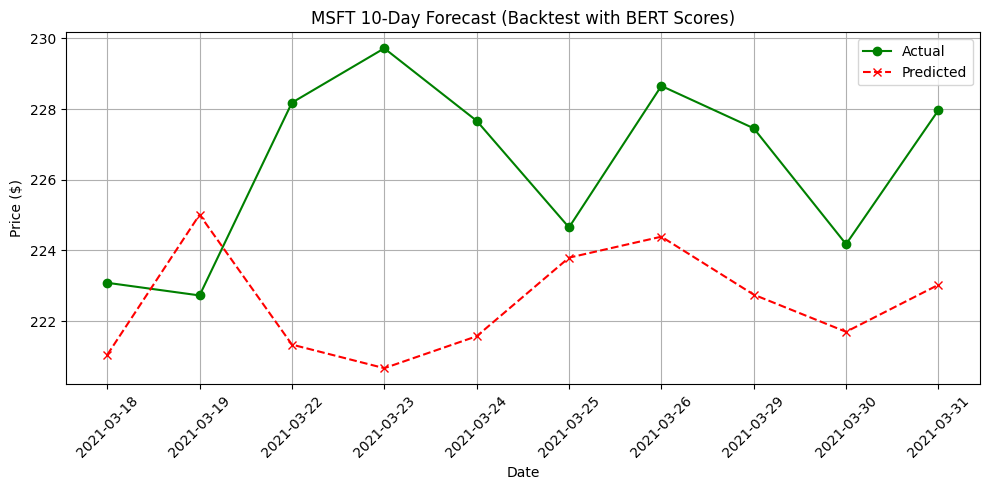

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Technical Indicators (unchanged)
def calculate_indicators(df):
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_50'] = df['Close'].rolling(50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return df.dropna()

# 2. Prepare data for LSTM
# (Removed FinBERT as a feature; using only technical indicators)
def prepare_data(df):
    features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'OBV']
    df = df[features].dropna()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)
    X, y = [], []
    # Using past 90 days to predict the next 10 days (Close price only)
    for i in range(90, len(scaled) - 10 + 1):
        X.append(scaled[i-90:i])
        y.append(scaled[i:i+10, 0])
    return np.array(X), np.array(y), scaler, df

# 3. Build model
def build_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(10)  # 10-day prediction output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# 4. Inverse transform helper (unchanged)
def inverse_transform_predictions(pred, scaler, n_features):
    inv = []
    for i in range(pred.shape[1]):
        dummy = np.zeros((pred.shape[0], n_features))
        dummy[:, 0] = pred[:, i]
        inv_step = scaler.inverse_transform(dummy)[:, 0]
        inv.append(inv_step)
    return np.stack(inv, axis=1)

# === Main ===
# Download MSFT data (2018-01-01 to 2021-04-01)
df = yf.download('MSFT', start='2018-01-01', end='2021-04-01', progress=False)
df = calculate_indicators(df)
# Remove the add_finbert call so FinBERT scores are no longer used
X, y, scaler, processed_df = prepare_data(df)

# Use the last sample for testing (predict 18–31 March), remove it from training
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[-1].reshape(1, 90, X.shape[2]), y[-1]

# Build and train the LSTM model
model = build_model((X.shape[1], X.shape[2]))
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predict the next 10 days using the last available sequence
pred = model.predict(X_test)
pred_inv = inverse_transform_predictions(pred, scaler, X.shape[2])[0]
actual_inv = inverse_transform_predictions(y_test.reshape(1, -1), scaler, X.shape[2])[0]

# Forecast dates for the 10-day prediction period
backtest_dates = [
    '2021-03-18', '2021-03-19', '2021-03-22', '2021-03-23', '2021-03-24',
    '2021-03-25', '2021-03-26', '2021-03-29', '2021-03-30', '2021-03-31'
]

# Provided BERT scores for these 10 forecast days
bert_forecast_scores = [
    0.99890983,
    0.98359287,
    0.99987495,
    0.3688303,
    0.009381682,
    0.01001513,
    0.5373137,
    0.7568087,
    0.004190296,
    0.005011648
]

# Build a DataFrame for forecast results including the BERT scores
results = pd.DataFrame({
    'Date': backtest_dates,
    'Actual': actual_inv,
    'Predicted': pred_inv,
    'BERT': bert_forecast_scores
})

# Evaluation metrics for the forecast (comparing predicted vs actual Close prices)
mae = mean_absolute_error(actual_inv, pred_inv)
rmse = np.sqrt(mean_squared_error(actual_inv, pred_inv))
r2 = r2_score(actual_inv, pred_inv)
mape = np.mean(np.abs((actual_inv - pred_inv) / actual_inv)) * 100

print("\n=== Backtest Results ===")
print(results)
print(f"\nMAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Plot the forecast results
plt.figure(figsize=(10, 5))
plt.plot(results['Date'], results['Actual'], 'go-', label='Actual')
plt.plot(results['Date'], results['Predicted'], 'rx--', label='Predicted')
plt.title('MSFT 10-Day Forecast (Backtest with BERT Scores)')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


ROBERTA 10 DAYS

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step

=== Backtest Results (with shifted RoBERTa scores) ===
         Date      Actual   Predicted   RoBERTa
0  2021-03-18  223.084488  224.382754       NaN
1  2021-03-19  222.726730  226.520474  0.926582
2  2021-03-22  228.180069  225.166882  0.741147
3  2021-03-23  229.717438  225.899832  0.954768
4  2021-03-24  227.667618  226.534650  0.896554
5  2021-03-25  224.650833  226.386610  0.835641
6  2021-03-26  228.653824  225.273106  0.345039
7  2021-03-29  227.454895  226.579596  0.806674
8  2021-03-30  224.177063  227.325027  0.711344
9  2021-03-31  227.967316  225.804117  0.565143

MAE: $2.44
RMSE: $2.66
R²: -0.2443
MAPE: 1.08%


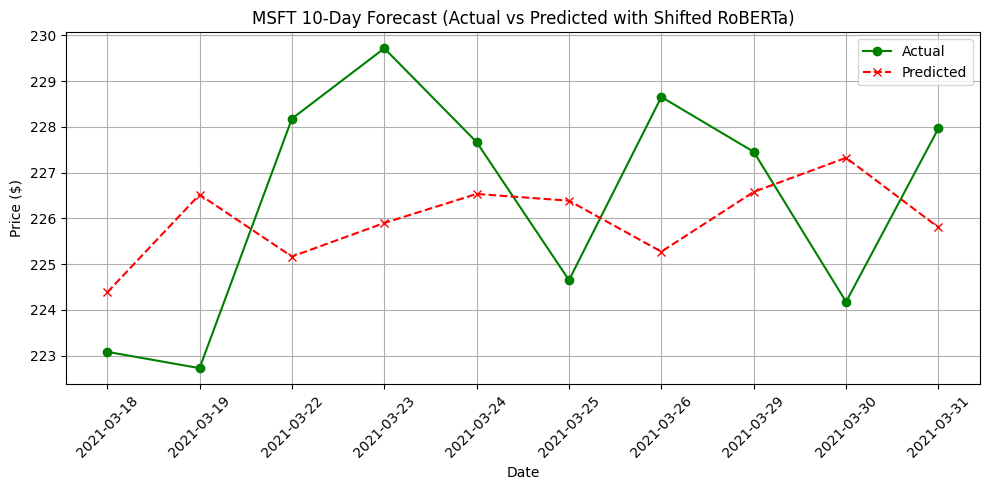

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Technical Indicators
def calculate_indicators(df):
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_50'] = df['Close'].rolling(50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return df.dropna()

# 2. Prepare data for LSTM (using only technical indicators)
def prepare_data(df):
    features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'OBV']
    df = df[features].dropna()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)
    X, y = [], []
    # Using past 90 days to predict the next 10 days of 'Close'
    for i in range(90, len(scaled) - 10 + 1):
        X.append(scaled[i-90:i])
        y.append(scaled[i:i+10, 0])
    return np.array(X), np.array(y), scaler, df

# 3. Build model
def build_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(10)  # 10-day prediction output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# 4. Inverse transform helper
def inverse_transform_predictions(pred, scaler, n_features):
    inv = []
    for i in range(pred.shape[1]):
        dummy = np.zeros((pred.shape[0], n_features))
        dummy[:, 0] = pred[:, i]
        inv_step = scaler.inverse_transform(dummy)[:, 0]
        inv.append(inv_step)
    return np.stack(inv, axis=1)

# === Main ===
# Download MSFT stock data from 2018-01-01 to 2021-04-01
df = yf.download('MSFT', start='2018-01-01', end='2021-04-01', progress=False)
df = calculate_indicators(df)
X, y, scaler, processed_df = prepare_data(df)

# Use the last sample for testing (predict 18–31 March) and the rest for training
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[-1].reshape(1, 90, X.shape[2]), y[-1]

# Build and train the LSTM model
model = build_model((X.shape[1], X.shape[2]))
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predict the next 10 days using the last available sequence
pred = model.predict(X_test)
pred_inv = inverse_transform_predictions(pred, scaler, X.shape[2])[0]
actual_inv = inverse_transform_predictions(y_test.reshape(1, -1), scaler, X.shape[2])[0]

# Forecast dates
backtest_dates = [
    '2021-03-18', '2021-03-19', '2021-03-22', '2021-03-23', '2021-03-24',
    '2021-03-25', '2021-03-26', '2021-03-29', '2021-03-30', '2021-03-31'
]

# RoBERTa sentiment scores (before shifting)
roberta_raw_scores = [
    0.9265822902409968,
    0.7411472812173561,
    0.9547679535683322,
    0.8965536110962136,
    0.8356414315811521,
    0.34503874654654476,
    0.8066737921123764,
    0.7113444394285735,
    0.5651427457486975,
    0.6825135340535635
]

# Apply shift(1): today's forecast uses yesterday's score
roberta_shifted_scores = [np.nan] + roberta_raw_scores[:-1]

# Build results DataFrame
results = pd.DataFrame({
    'Date': backtest_dates,
    'Actual': actual_inv,
    'Predicted': pred_inv,
    'RoBERTa': roberta_shifted_scores
})

# Evaluation metrics
mae = mean_absolute_error(actual_inv, pred_inv)
rmse = np.sqrt(mean_squared_error(actual_inv, pred_inv))
r2 = r2_score(actual_inv, pred_inv)
mape = np.mean(np.abs((actual_inv - pred_inv) / actual_inv)) * 100

print("\n=== Backtest Results (with shifted RoBERTa scores) ===")
print(results)
print(f"\nMAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# === Final Plot: Actual vs Predicted Prices ===
plt.figure(figsize=(10, 5))
plt.plot(results['Date'], results['Actual'], 'go-', label='Actual')
plt.plot(results['Date'], results['Predicted'], 'rx--', label='Predicted')
plt.title('MSFT 10-Day Forecast (Actual vs Predicted with Shifted RoBERTa)')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


10 DAYS WITHOUT SCORE

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step

=== Backtest Results (Without FinBERT) ===
         Date      Actual   Predicted
0  2021-03-18  223.084442  226.337146
1  2021-03-19  222.726715  227.729767
2  2021-03-22  228.180038  227.486493
3  2021-03-23  229.717453  229.590026
4  2021-03-24  227.667603  225.867109
5  2021-03-25  224.650864  230.418534
6  2021-03-26  228.653824  227.981948
7  2021-03-29  227.454910  227.145597
8  2021-03-30  224.177094  229.417652
9  2021-03-31  227.967361  228.800835

MAE: $2.37
RMSE: $3.18
R²: -0.7804
MAPE: 1.06%


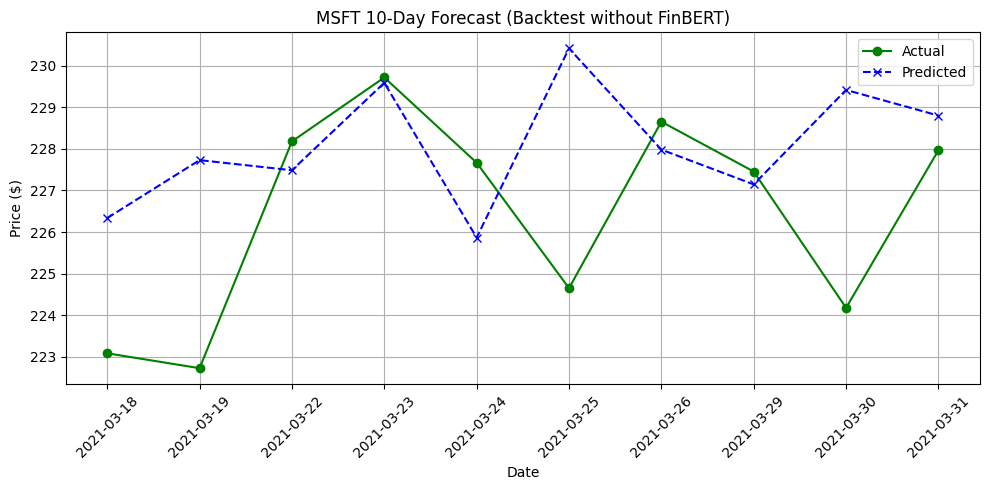

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Technical indicators
def calculate_indicators(df):
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_50'] = df['Close'].rolling(50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return df.dropna()

# 2. Prepare data for LSTM
def prepare_data(df):
    features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'OBV']
    df = df[features].dropna()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)
    X, y = [], []
    for i in range(90, len(scaled) - 10 + 1):
        X.append(scaled[i-90:i])
        y.append(scaled[i:i+10, 0])  # Predict next 10 days of Close
    return np.array(X), np.array(y), scaler, df

# 3. Build model
def build_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(10)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# 4. Inverse transform helper
def inverse_transform_predictions(pred, scaler, n_features):
    inv = []
    for i in range(pred.shape[1]):
        dummy = np.zeros((pred.shape[0], n_features))
        dummy[:, 0] = pred[:, i]
        inv_step = scaler.inverse_transform(dummy)[:, 0]
        inv.append(inv_step)
    return np.stack(inv, axis=1)

# === Main ===
df = yf.download('MSFT', start='2018-01-01', end='2021-04-01', progress=False)
df = calculate_indicators(df)
X, y, scaler, processed_df = prepare_data(df)

# Use last row for backtesting (18-31 March), remove it from training
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[-1].reshape(1, 90, X.shape[2]), y[-1]

model = build_model((X.shape[1], X.shape[2]))
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predict
pred = model.predict(X_test)
pred_inv = inverse_transform_predictions(pred, scaler, X.shape[2])[0]
actual_inv = inverse_transform_predictions(y_test.reshape(1, -1), scaler, X.shape[2])[0]

# Dates for the backtest period
backtest_dates = [
    '2021-03-18', '2021-03-19', '2021-03-22', '2021-03-23', '2021-03-24',
    '2021-03-25', '2021-03-26', '2021-03-29', '2021-03-30', '2021-03-31'
]

results = pd.DataFrame({
    'Date': backtest_dates,
    'Actual': actual_inv,
    'Predicted': pred_inv
})

# Evaluation
mae = mean_absolute_error(actual_inv, pred_inv)
rmse = np.sqrt(mean_squared_error(actual_inv, pred_inv))
r2 = r2_score(actual_inv, pred_inv)
mape = np.mean(np.abs((actual_inv - pred_inv) / actual_inv)) * 100

print("\n=== Backtest Results (Without FinBERT) ===")
print(results)
print(f"\nMAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(results['Date'], results['Actual'], 'go-', label='Actual')
plt.plot(results['Date'], results['Predicted'], 'bx--', label='Predicted')
plt.title('MSFT 10-Day Forecast (Backtest without FinBERT)')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


LSTM 30 DAYS(WITH FINBERT)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step

=== Backtest Results ===
          Date      Actual   Predicted  FinBERT_Shifted
0   2021-03-01  235.721924  226.410963              NaN
1   2021-03-02  232.995224  227.085291         0.665576
2   2021-03-03  226.749023  226.746543         0.500001
3   2021-03-04  225.550064  231.213153         0.999525
4   2021-03-05  226.787674  230.817284         0.999998
5   2021-03-08  221.411713  229.222464         0.500487
6   2021-03-09  224.689514  228.909495         0.499997
7   2021-03-10  229.098602  226.389138         0.499994
8   2021-03-11  226.130203  225.006425         0.999997
9   2021-03-12  220.029037  231.334128         0.499994
10  2021-03-15  219.226517  226.166393         0.553531
11  2021-03-16  223.935364  226.409064         0.992431
12  2021-03-17  219.864670  227.853168         0.999870
13  2021-03-18  226.043198  228.133368         0.499995
14  2021-03-19  224.728210  228.776344         0.995116
15  2021-03-22  229.282333  226.100993 

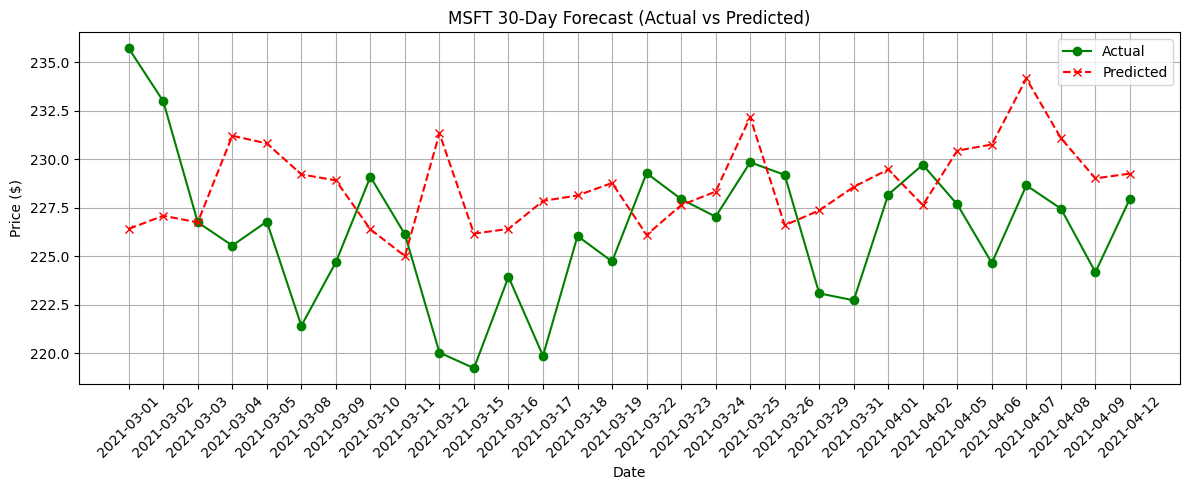

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Technical indicators
def calculate_indicators(df):
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_50'] = df['Close'].rolling(50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return df.dropna()

# 2. Prepare data for LSTM
def prepare_data(df):
    features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'OBV']
    df = df[features].dropna()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    X, y = [], []
    forecast_horizon = 30
    for i in range(90, len(scaled) - forecast_horizon + 1):
        X.append(scaled[i-90:i])
        y.append(scaled[i:i+forecast_horizon, 0])
    return np.array(X), np.array(y), scaler, df

# 3. LSTM model
def build_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(30)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# 4. Inverse transform predictions
def inverse_transform_predictions(pred, scaler, n_features):
    inv = []
    for i in range(pred.shape[1]):
        dummy = np.zeros((pred.shape[0], n_features))
        dummy[:, 0] = pred[:, i]
        inv_step = scaler.inverse_transform(dummy)[:, 0]
        inv.append(inv_step)
    return np.stack(inv, axis=1)

# === Main Execution ===
df = yf.download('MSFT', start='2018-01-01', end='2021-04-01', progress=False)
df = calculate_indicators(df)
X, y, scaler, processed_df = prepare_data(df)

X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[-1].reshape(1, 90, X.shape[2]), y[-1]

model = build_model((X.shape[1], X.shape[2]))
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

pred = model.predict(X_test)
pred_inv = inverse_transform_predictions(pred, scaler, X.shape[2])[0]
actual_inv = inverse_transform_predictions(y_test.reshape(1, -1), scaler, X.shape[2])[0]

# Forecast dates
backtest_dates = [
    '2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
    '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12',
    '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18', '2021-03-19',
    '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26',
    '2021-03-29', '2021-03-31', '2021-04-01', '2021-04-02', '2021-04-05',
    '2021-04-06', '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-12'
]

# FinBERT scores
finbert_forecast_scores = [
    0.66557646, 0.50000095, 0.9995247, 0.99999774, 0.5004875,
    0.49999735, 0.49999407, 0.9999969, 0.499994, 0.5535309,
    0.9924311, 0.9998701, 0.49999472, 0.99511623, 0.49999523,
    0.99941087, 0.49999413, 0.99885404, 0.87711656, 0.10364249,
    0.99789953, 0.96266353, 0.5039, 0.50000453, 0.7315824,
    0.9956836, 0.50038534, 0.99999833, 0.9911664, 0.995677
]

# Shift FinBERT scores by 1 day
finbert_shifted = [None] + finbert_forecast_scores[:-1]

# Create results DataFrame
results = pd.DataFrame({
    'Date': backtest_dates,
    'Actual': actual_inv,
    'Predicted': pred_inv,
    'FinBERT_Shifted': finbert_shifted
})

# Evaluation
mae = mean_absolute_error(actual_inv, pred_inv)
rmse = np.sqrt(mean_squared_error(actual_inv, pred_inv))
r2 = r2_score(actual_inv, pred_inv)
mape = np.mean(np.abs((actual_inv - pred_inv) / actual_inv)) * 100

print("\n=== Backtest Results ===")
print(results)
print(f"\nMAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# === Plot 1: Actual vs Predicted ===
plt.figure(figsize=(12, 5))
plt.plot(results['Date'], results['Actual'], 'go-', label='Actual')
plt.plot(results['Date'], results['Predicted'], 'rx--', label='Predicted')
plt.title('MSFT 30-Day Forecast (Actual vs Predicted)')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




In [ ]:
30 DAYS WITHOUT SCORE

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step

=== Backtest Results ===
          Date      Actual   Predicted
0   2021-03-01  235.721909  240.780255
1   2021-03-02  232.995239  239.302910
2   2021-03-03  226.749054  235.247273
3   2021-03-04  225.550064  238.478746
4   2021-03-05  226.787704  238.947737
5   2021-03-08  221.411743  238.299427
6   2021-03-09  224.689514  237.204220
7   2021-03-10  229.098618  235.633132
8   2021-03-11  226.130203  239.490099
9   2021-03-12  220.029053  237.141607
10  2021-03-15  219.226486  233.455746
11  2021-03-16  223.935349  230.791331
12  2021-03-17  219.864685  239.803717
13  2021-03-18  226.043182  234.943063
14  2021-03-19  224.728226  239.506044
15  2021-03-22  229.282333  240.630345
16  2021-03-23  227.947998  239.225576
17  2021-03-24  227.039108  231.835055
18  2021-03-25  229.843155  237.413094
19  2021-03-26  229.195312  235.388201
20  2021-03-29  223.084473  237.765990
21  2021-03-31  222.726700  238.317576
22  2021-04-01  228.180054  237.342371

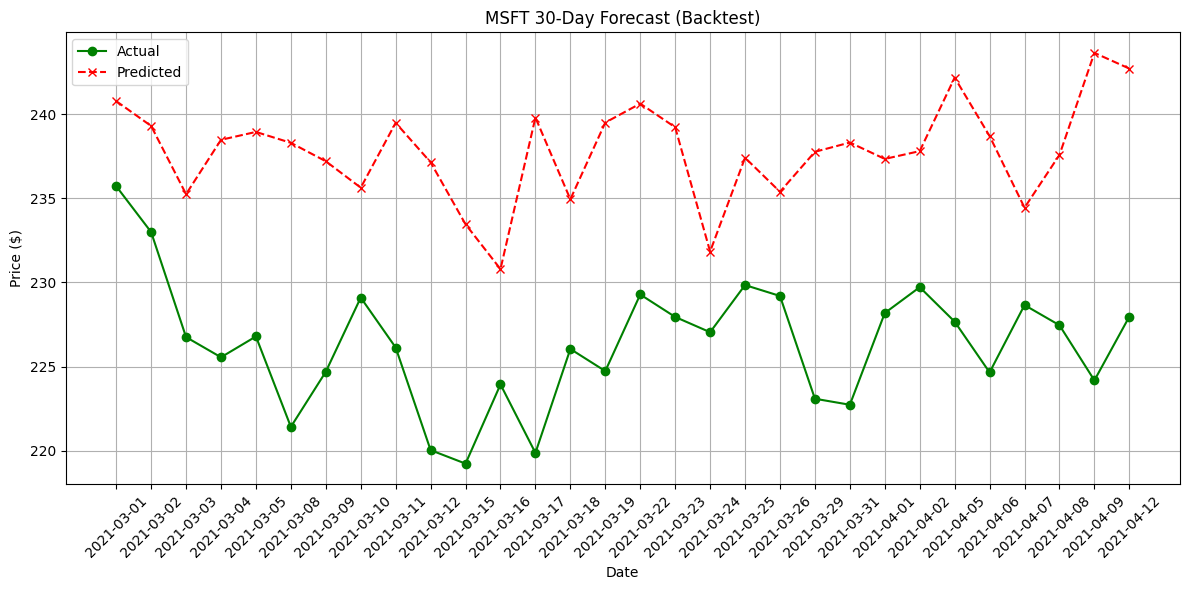

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Technical indicators
def calculate_indicators(df):
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_50'] = df['Close'].rolling(50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return df.dropna()

# 2. Prepare data for LSTM with 30-day forecast horizon
def prepare_data(df):
    features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'OBV']
    df = df[features].dropna()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    X, y = [], []
    forecast_horizon = 30  # now forecasting 30 days
    # Use the past 90 days to predict the next 30 days (Close price only)
    for i in range(90, len(scaled) - forecast_horizon + 1):
        X.append(scaled[i-90:i])
        y.append(scaled[i:i+forecast_horizon, 0])  # predicting the next 30 days of 'Close'
    return np.array(X), np.array(y), scaler, df

# 3. Build model with adjusted output (30 days)
def build_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(30)  # outputs 30 predictions
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# 4. Inverse transform helper for predictions
def inverse_transform_predictions(pred, scaler, n_features):
    inv = []
    for i in range(pred.shape[1]):
        dummy = np.zeros((pred.shape[0], n_features))
        dummy[:, 0] = pred[:, i]
        inv_step = scaler.inverse_transform(dummy)[:, 0]
        inv.append(inv_step)
    return np.stack(inv, axis=1)

# === Main ===
# Download MSFT stock data
df = yf.download('MSFT', start='2018-01-01', end='2021-04-01', progress=False)
df = calculate_indicators(df)
X, y, scaler, processed_df = prepare_data(df)

# Split data: use all but the last sample for training and the last sample for testing
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[-1].reshape(1, 90, X.shape[2]), y[-1]  # y_test shape: (30,)

# Build and train the LSTM model
model = build_model((X.shape[1], X.shape[2]))
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predict the next 30 days using the last available sequence
pred = model.predict(X_test)
pred_inv = inverse_transform_predictions(pred, scaler, X.shape[2])[0]
actual_inv = inverse_transform_predictions(y_test.reshape(1, -1), scaler, X.shape[2])[0]

# Define 30 forecast dates (as strings)
backtest_dates = [
    '2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
    '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12',
    '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18', '2021-03-19',
    '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26',
    '2021-03-29', '2021-03-31', '2021-04-01', '2021-04-02', '2021-04-05',
    '2021-04-06', '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-12'
]

# Compile forecast results into a DataFrame without FinBERT scores
results = pd.DataFrame({
    'Date': backtest_dates,
    'Actual': actual_inv,
    'Predicted': pred_inv
})

# Calculate evaluation metrics for the forecast
mae = mean_absolute_error(actual_inv, pred_inv)
rmse = np.sqrt(mean_squared_error(actual_inv, pred_inv))
r2 = r2_score(actual_inv, pred_inv)
mape = np.mean(np.abs((actual_inv - pred_inv) / actual_inv)) * 100

print("\n=== Backtest Results ===")
print(results)
print(f"\nMAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Plot the forecast results
plt.figure(figsize=(12, 6))
plt.plot(results['Date'], results['Actual'], 'go-', label='Actual')
plt.plot(results['Date'], results['Predicted'], 'rx--', label='Predicted')
plt.title('MSFT 30-Day Forecast (Backtest)')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


BERT 30 DAYS - SCORE

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step

=== Backtest Results ===
          Date      Actual   Predicted  BERT_shifted
0   2021-03-01  235.721924  219.864116           NaN
1   2021-03-02  232.995224  220.272763      0.997117
2   2021-03-03  226.749023  222.032021      0.999966
3   2021-03-04  225.550064  220.488481      0.220884
4   2021-03-05  226.787674  221.183948      0.006010
5   2021-03-08  221.411713  221.986974      0.993533
6   2021-03-09  224.689514  222.991985      0.998935
7   2021-03-10  229.098602  222.261739      0.999510
8   2021-03-11  226.130203  221.921815      0.996491
9   2021-03-12  220.029037  224.968035      0.999925
10  2021-03-15  219.226517  224.064304      0.998820
11  2021-03-16  223.935364  222.377769      0.045634
12  2021-03-17  219.864670  224.154666      0.993145
13  2021-03-18  226.043198  223.604887      0.998910
14  2021-03-19  224.728210  223.989432      0.983593
15  2021-03-22  229.282333  225.168539      0.999875
16  2021-03-23  227.947998  225.80

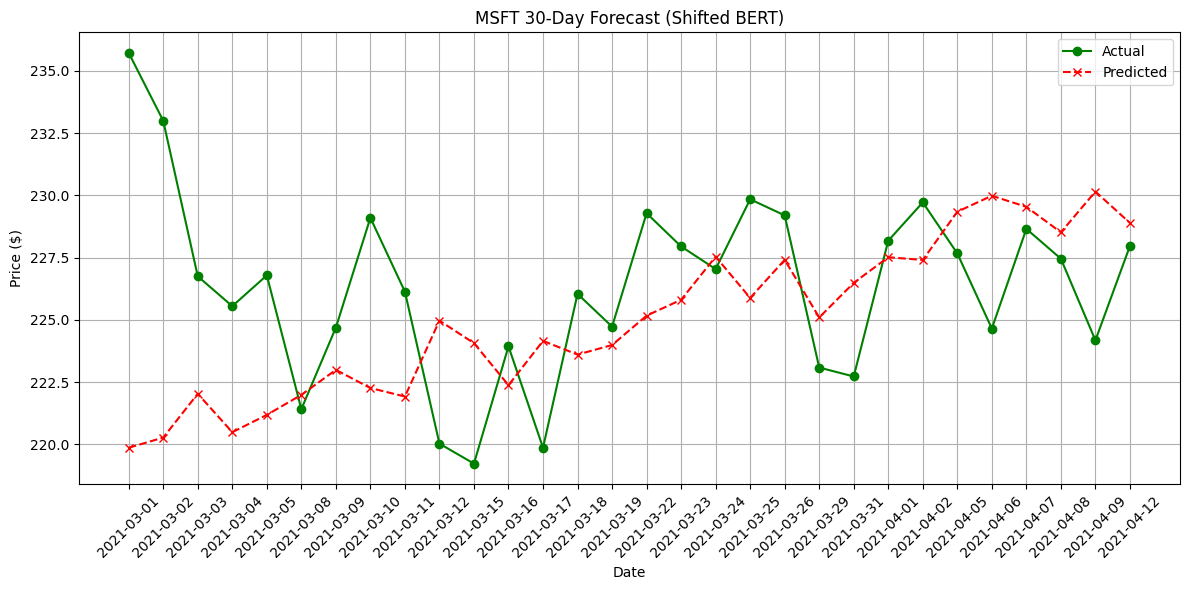

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Technical indicators
def calculate_indicators(df):
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_50'] = df['Close'].rolling(50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return df.dropna()

# 2. Prepare data
def prepare_data(df):
    features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'OBV']
    df = df[features].dropna()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    X, y = [], []
    forecast_horizon = 30
    for i in range(90, len(scaled) - forecast_horizon + 1):
        X.append(scaled[i-90:i])
        y.append(scaled[i:i+forecast_horizon, 0])
    return np.array(X), np.array(y), scaler, df

# 3. LSTM model
def build_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(30)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# 4. Inverse transform helper
def inverse_transform_predictions(pred, scaler, n_features):
    inv = []
    for i in range(pred.shape[1]):
        dummy = np.zeros((pred.shape[0], n_features))
        dummy[:, 0] = pred[:, i]
        inv_step = scaler.inverse_transform(dummy)[:, 0]
        inv.append(inv_step)
    return np.stack(inv, axis=1)

# === Main ===
df = yf.download('MSFT', start='2018-01-01', end='2021-04-01', progress=False)
df = calculate_indicators(df)
X, y, scaler, processed_df = prepare_data(df)

X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[-1].reshape(1, 90, X.shape[2]), y[-1]

model = build_model((X.shape[1], X.shape[2]))
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

pred = model.predict(X_test)
pred_inv = inverse_transform_predictions(pred, scaler, X.shape[2])[0]
actual_inv = inverse_transform_predictions(y_test.reshape(1, -1), scaler, X.shape[2])[0]

# Forecast dates
backtest_dates = [
    '2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
    '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12',
    '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18', '2021-03-19',
    '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26',
    '2021-03-29', '2021-03-31', '2021-04-01', '2021-04-02', '2021-04-05',
    '2021-04-06', '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-12'
]

# Original BERT scores
bert_forecast_scores = [
    0.99711657, 0.9999659, 0.22088444, 0.006009996, 0.9935329, 0.9989352,
    0.99951035, 0.9964912, 0.99992466, 0.9988198, 0.04563424, 0.9931446,
    0.99890983, 0.98359287, 0.99987495, 0.3688303, 0.009381682, 0.01001513,
    0.5373137, 0.7568087, 0.004190296, 0.005011648, 0.9990215, 0.9990713,
    0.9041441, 0.99734116, 0.99874437, 0.003255725, 0.9960073, 0.9237397
]

# Shift BERT scores by 1 day to reflect impact on next day
bert_shifted = [None] + bert_forecast_scores[:-1]

# Create results DataFrame
results = pd.DataFrame({
    'Date': backtest_dates,
    'Actual': actual_inv,
    'Predicted': pred_inv,
    'BERT_shifted': bert_shifted
})

# Evaluation
mae = mean_absolute_error(actual_inv, pred_inv)
rmse = np.sqrt(mean_squared_error(actual_inv, pred_inv))
r2 = r2_score(actual_inv, pred_inv)
mape = np.mean(np.abs((actual_inv - pred_inv) / actual_inv)) * 100

print("\n=== Backtest Results ===")
print(results)
print(f"\nMAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Plot only Actual and Predicted
plt.figure(figsize=(12, 6))
plt.plot(results['Date'], results['Actual'], 'go-', label='Actual')
plt.plot(results['Date'], results['Predicted'], 'rx--', label='Predicted')
plt.title('MSFT 30-Day Forecast (Shifted BERT)')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


ROBERTA 30 DAYS

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step

=== Backtest Results ===
          Date      Actual   Predicted  RoBERTa_shifted
0   2021-03-01  235.721924  220.413627              NaN
1   2021-03-02  232.995224  222.329194         0.908617
2   2021-03-03  226.749023  222.949827         0.980336
3   2021-03-04  225.550064  221.465732         0.821638
4   2021-03-05  226.787674  221.880315         0.375727
5   2021-03-08  221.411713  223.218518         0.700971
6   2021-03-09  224.689514  223.136294         0.927110
7   2021-03-10  229.098602  222.914928         0.995257
8   2021-03-11  226.130203  225.617789         0.706026
9   2021-03-12  220.029037  226.489483         0.994465
10  2021-03-15  219.226517  220.754125         0.977599
11  2021-03-16  223.935364  223.980987         0.420516
12  2021-03-17  219.864670  222.323851         0.824849
13  2021-03-18  226.043198  224.155231         0.926582
14  2021-03-19  224.728210  219.537415         0.741147
15  2021-03-22  229.282333  222.475095 

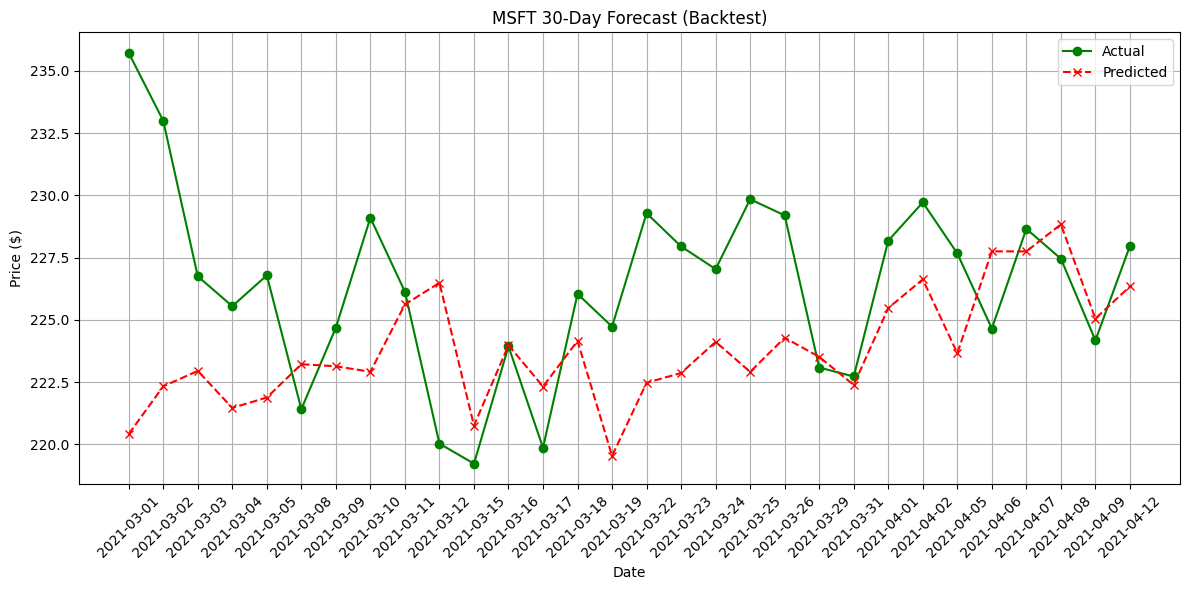

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Technical indicators
def calculate_indicators(df):
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_50'] = df['Close'].rolling(50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return df.dropna()

# 2. Prepare data for LSTM (forecast next 30 days using past 90)
def prepare_data(df):
    features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'OBV']
    df = df[features].dropna()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    X, y = [], []
    forecast_horizon = 30
    for i in range(90, len(scaled) - forecast_horizon + 1):
        X.append(scaled[i-90:i])  # Past 90 days
        y.append(scaled[i:i+forecast_horizon, 0])  # Next 30 days of 'Close'
    return np.array(X), np.array(y), scaler, df

# 3. Build LSTM model
def build_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(30)  # 30-day output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# 4. Inverse transform predictions
def inverse_transform_predictions(pred, scaler, n_features):
    inv = []
    for i in range(pred.shape[1]):
        dummy = np.zeros((pred.shape[0], n_features))
        dummy[:, 0] = pred[:, i]
        inv_step = scaler.inverse_transform(dummy)[:, 0]
        inv.append(inv_step)
    return np.stack(inv, axis=1)

# === Main ===
df = yf.download('MSFT', start='2018-01-01', end='2021-04-01', progress=False)
df = calculate_indicators(df)
X, y, scaler, processed_df = prepare_data(df)

X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[-1].reshape(1, 90, X.shape[2]), y[-1]

model = build_model((X.shape[1], X.shape[2]))
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

pred = model.predict(X_test)
pred_inv = inverse_transform_predictions(pred, scaler, X.shape[2])[0]
actual_inv = inverse_transform_predictions(y_test.reshape(1, -1), scaler, X.shape[2])[0]

# Define forecast dates
backtest_dates = [
    '2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
    '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12',
    '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18', '2021-03-19',
    '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26',
    '2021-03-29', '2021-03-31', '2021-04-01', '2021-04-02', '2021-04-05',
    '2021-04-06', '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-12'
]

# RoBERTa sentiment scores (shifted by 1 to simulate impact on next day)
roberta_forecast_scores = [
    0.9086170033517184, 0.9803358390634613, 0.8216375096299793, 0.3757271575763743, 0.7009710883140015,
    0.9271097308785876, 0.9952567644930397, 0.7060260444753372, 0.9944648645285543, 0.9775986938278183,
    0.42051644138180716, 0.8248492740195579, 0.9265822902409968, 0.7411472812173561, 0.9547679535683322,
    0.8965536110962136, 0.8356414315811521, 0.34503874654654476, 0.8066737921123764, 0.7113444394285735,
    0.5651427457486975, 0.6825135340535635, 0.9057091824360437, 0.9332902315657243, 0.884763968555135,
    0.8149000079812874, 0.8795633574165516, 0.42896534942343995, 0.9026358237061691, 0.8584133327196046
]
roberta_shifted = [None] + roberta_forecast_scores[:-1]  # Shift by 1

# Create results DataFrame
results = pd.DataFrame({
    'Date': backtest_dates,
    'Actual': actual_inv,
    'Predicted': pred_inv,
    'RoBERTa_shifted': roberta_shifted
})

# Evaluate
mae = mean_absolute_error(actual_inv, pred_inv)
rmse = np.sqrt(mean_squared_error(actual_inv, pred_inv))
r2 = r2_score(actual_inv, pred_inv)
mape = np.mean(np.abs((actual_inv - pred_inv) / actual_inv)) * 100

print("\n=== Backtest Results ===")
print(results)
print(f"\nMAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(results['Date'], results['Actual'], 'go-', label='Actual')
plt.plot(results['Date'], results['Predicted'], 'rx--', label='Predicted')
plt.title('MSFT 30-Day Forecast (Backtest)')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


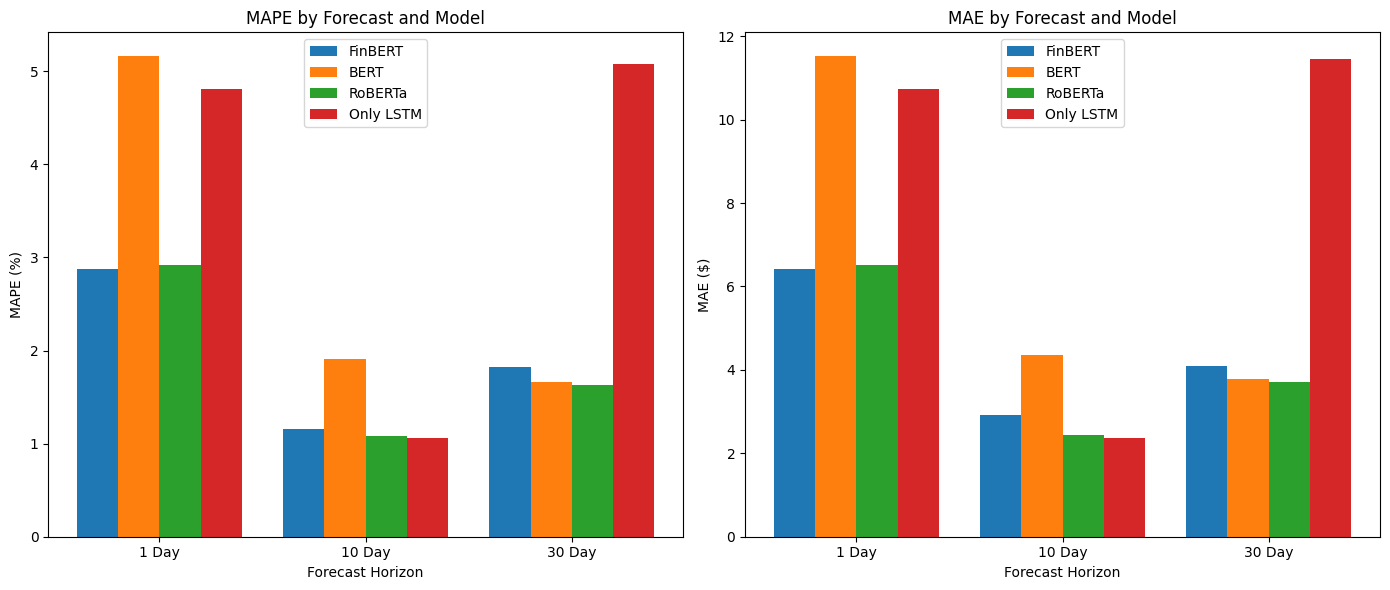

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample Data
models = ['FinBERT', 'BERT', 'RoBERTa', 'Only LSTM']
forecasts = ['1 Day', '10 Day', '30 Day']

# Each entry is a list of values [1 day, 10 day, 30 day] for each model
mape = {
    'FinBERT': [2.88, 1.16, 1.82],
    'BERT': [5.16, 1.91, 1.66],
    'RoBERTa': [2.92, 1.08, 1.63],
    'Only LSTM': [4.81, 1.06, 5.08]
}

mae = {
    'FinBERT': [6.4295, 2.91, 4.10],
    'BERT': [11.5158, 4.36, 3.77],
    'RoBERTa': [6.5159, 2.44, 3.72],
    'Only LSTM': [10.7327, 2.37, 11.45]
}

x = np.arange(len(forecasts))  # [0, 1, 2]
width = 0.2  # Width of each bar

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot MAPE
for i, model in enumerate(models):
    ax1.bar(x + i * width, mape[model], width, label=model)
ax1.set_xlabel('Forecast Horizon')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('MAPE by Forecast and Model')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(forecasts)
ax1.legend()

# Plot MAE
for i, model in enumerate(models):
    ax2.bar(x + i * width, mae[model], width, label=model)
ax2.set_xlabel('Forecast Horizon')
ax2.set_ylabel('MAE ($)')
ax2.set_title('MAE by Forecast and Model')
ax2.set_xticks(x + width * 1.5)
ax2.set_xticklabels(forecasts)
ax2.legend()

plt.tight_layout()
plt.show()